In [38]:
#Imports
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Preprocessing the data: 

## 1.1 Loading the dataset : 

In [39]:
#Loading the dataframe.
df = pd.read_csv('./Table_Ciqual_2016.csv',delimiter=';',encoding='latin-1')
#Showing the first 10 rows of the dataframe.
df.head(10)

,ORIGGPCD,ORIGGPFR,ORIGFDCD,ORIGFDNM,"Energie, Règlement UE N° 1169/2011 (kJ/100g)","Energie, Règlement UE N° 1169/2011 (kcal/100g)","Energie, N x facteur Jones, avec fibres (kJ/100g)","Energie, N x facteur Jones, avec fibres (kcal/100g)",Eau (g/100g),Protéines (g/100g),...,Vitamine K1 (µg/100g),Vitamine K2 (µg/100g),Vitamine C (mg/100g),Vitamine B1 ou Thiamine (mg/100g),Vitamine B2 ou Riboflavine (mg/100g),Vitamine B3 ou PP ou Niacine (mg/100g),Vitamine B5 ou Acide pantothénique (mg/100g),Vitamine B6 (mg/100g),Vitamine B9 ou Folates totaux (µg/100g),Vitamine B12 (µg/100g)
0,1.1,Farines et amidons,4090,Fécule de pomme de terre,1480,348,1480,348,12.7,0,...,-,-,0,0.0055,0.005,0.12,-,0.01,82,0
1,1.1,Farines et amidons,9311,Flocon d'avoine,1550,367,1530,364,10.1,13.3,...,2,-,0,0.43,0.14,0.96,1.31,0.12,39.6,0
2,1.1,Farines et amidons,9410,Farine de blé tendre ou froment T110,1490,351,1470,348,9.96,10.3,...,16,-,< 0.5,0.41,0.083,2.45,0.6,0.17,37.3,0
3,1.1,Farines et amidons,9415,Farine de blé tendre ou froment T150,1430,338,1410,334,10.7,11.4,...,-,-,< 0.5,0.34,0.11,3.48,1.02,0.26,52.4,-
4,1.1,Farines et amidons,9435,Farine de blé tendre ou froment T65,1460,345,1440,341,13.2,12.6,...,-,-,-,0.19,0.05,1.46,0.5,0.08,18.3,-
5,1.1,Farines et amidons,9436,Farine de blé tendre ou froment T55 (pour pains),1470,348,1460,344,13.6,10.4,...,0.3,-,0,0.12,0.05,1.16,0.49,0.054,24.7,0
6,1.1,Farines et amidons,9437,Farine de blé tendre ou froment avec levure in...,1490,350,1470,346,-,9.12,...,-,-,-,-,-,-,-,-,-,-
7,1.1,Farines et amidons,9440,Farine de blé tendre ou froment T45 (pour pâti...,1490,351,1480,348,11.3,9.06,...,0,-,0,0.12,0.031,0.89,0.84,0.06,18,0
8,1.1,Farines et amidons,9445,Farine de blé tendre ou froment T80,1510,355,1490,352,10.7,9.95,...,-,-,< 0.5,0.26,0.06,1.5,0.5,0.13,53.8,-
9,1.1,Farines et amidons,9510,Amidon de maïs ou fécule de maïs,1550,364,1550,364,8.73,0.43,...,0,-,0,0,0.008,0.03,0,0.005,1,0


The missing values are put as '-' in the dataframe, also some of the values are marked as <(some number) which we will set to 0 , as it implies that the value is negligeable.

## 1.2 Cleaning the dataset :

In [40]:
#A list to keep track of values that couldn't be converted to a float
special_values=[]

def cleanup(food, columns) : 
    """
    Returns vector with columns provided in parameter columns and float values.
    :param food: list
    :param columns: list of strings
    :return: DataFrame with float values
    """
    vector = food[columns] 
    for i in columns : 
        #Skip columns with text.
        if(i in ['ORIGFDNM','ORIGGPFR']) : continue
        #convert string values to float.
        try : 
            vector[i]=float(vector[i])
        #If that is not possible set it to 0.
        except ValueError : 
            #Kepping track of characters that will be assigned 0.
            special_values.append(vector[i])
            vector[i]=0
    return vector

In [41]:
#Selecting columns that we will keep for our graph. 

columns= ['ORIGFDNM','ORIGGPFR', #These columns (ORIGFDNM and ORIGGPFR) are kept for later use. But they won't affect the computations to come.
          'Energie, Règlement UE N° 1169/2011 (kcal/100g)',
          'Protéines (g/100g)','Glucides (g/100g)',
          'Fibres alimentaires (g/100g)','Lipides (g/100g)',
          'AG saturés (g/100g)','Cholestérol (mg/100g)',
          'Alcool (g/100g)',
          'Sel chlorure de sodium (g/100g)',
          'Calcium (mg/100g)',
          'Chlorure (mg/100g)',
          'Cuivre (mg/100g)',
          'Fer (mg/100g)',
          'Iode (µg/100g)',
          'Magnésium (mg/100g)',
          'Manganèse (mg/100g)',
          'Phosphore (mg/100g)',
          'Potassium (mg/100g)',
          'Sélénium (µg/100g)',
          'Sodium (mg/100g)',
          'Zinc (mg/100g)',
          'Rétinol (µg/100g)',
          'Beta-Carotène (µg/100g)',
          'Vitamine D (µg/100g)',
          'Vitamine E (mg/100g)',
          'Vitamine K1 (µg/100g)',
          'Vitamine K2 (µg/100g)',
          'Vitamine C (mg/100g)',
          'Vitamine B1 ou Thiamine (mg/100g)',
          'Vitamine B2 ou Riboflavine (mg/100g)',
          'Vitamine B3 ou PP ou Niacine (mg/100g)',
          'Vitamine B5 ou Acide pantothénique (mg/100g)',
          'Vitamine B6 (mg/100g)',
          'Vitamine B9 ou Folates totaux (µg/100g)',
          'Vitamine B12 (µg/100g)']

In [42]:
#The vector is still in dataframe form.
vectors=df.apply(lambda x : cleanup(x,columns),axis=1)

In [43]:
#Checking the special characters that were set to 0. 
print(np.unique(special_values))

['-' '< 0.0001' '< 0.00018' '< 0.0002' '< 0.00024' '< 0.0005' '< 0.0008'
 '< 0.001' '< 0.0012' '< 0.0015' '< 0.0019' '< 0.002' '< 0.0023' '< 0.003'
 '< 0.0033' '< 0.005' '< 0.0054' '< 0.0063' '< 0.008' '< 0.0083' '< 0.01'
 '< 0.016' '< 0.017' '< 0.02' '< 0.022' '< 0.028' '< 0.033' '< 0.037'
 '< 0.04' '< 0.045' '< 0.05' '< 0.053' '< 0.063' '< 0.067' '< 0.07'
 '< 0.08' '< 0.09' '< 0.1' '< 0.13' '< 0.14' '< 0.15' '< 0.16' '< 0.17'
 '< 0.18' '< 0.19' '< 0.2' '< 0.25' '< 0.27' '< 0.28' '< 0.29' '< 0.3'
 '< 0.33' '< 0.34' '< 0.38' '< 0.39' '< 0.4' '< 0.42' '< 0.43' '< 0.44'
 '< 0.46' '< 0.5' '< 0.57' '< 0.58' '< 0.6' '< 0.7' '< 0.75' '< 0.77'
 '< 0.8' '< 0.81' '< 0.83' '< 0.98' '< 1' '< 1.11' '< 1.28' '< 1.5' '< 10'
 '< 100' '< 15' '< 16' '< 2' '< 2.1' '< 2.2' '< 2.5' '< 2.57' '< 2.58'
 '< 2.6' '< 2.72' '< 2.78' '< 2.97' '< 20' '< 200' '< 21' '< 3' '< 3.13'
 '< 3.35' '< 3.58' '< 3.59' '< 3.6' '< 30' '< 39' '< 4' '< 4.34' '< 4.5'
 '< 40' '< 5' '< 50' '< 6.25' '< 60' '< 61' '< 7.2' '< 7.5' '< 

**All the special character are of the form '-', '<(some float)' and 'traces'. **

In [44]:
#Showing the resulting dataframe.
vectors.head(10)

,ORIGFDNM,ORIGGPFR,"Energie, Règlement UE N° 1169/2011 (kcal/100g)",Protéines (g/100g),Glucides (g/100g),Fibres alimentaires (g/100g),Lipides (g/100g),AG saturés (g/100g),Cholestérol (mg/100g),Alcool (g/100g),...,Vitamine K1 (µg/100g),Vitamine K2 (µg/100g),Vitamine C (mg/100g),Vitamine B1 ou Thiamine (mg/100g),Vitamine B2 ou Riboflavine (mg/100g),Vitamine B3 ou PP ou Niacine (mg/100g),Vitamine B5 ou Acide pantothénique (mg/100g),Vitamine B6 (mg/100g),Vitamine B9 ou Folates totaux (µg/100g),Vitamine B12 (µg/100g)
0,Fécule de pomme de terre,Farines et amidons,348.0,0.00,86.3,0.55,0.20,0.039,0.0,0.0,...,0.0,0.0,0.0,0.0055,0.005,0.12,0.00,0.010,82.0,0.0
1,Flocon d'avoine,Farines et amidons,367.0,13.30,57.9,10.20,6.51,1.130,0.0,0.0,...,2.0,0.0,0.0,0.4300,0.140,0.96,1.31,0.120,39.6,0.0
2,Farine de blé tendre ou froment T110,Farines et amidons,351.0,10.30,70.6,7.00,1.13,0.170,0.0,0.0,...,16.0,0.0,0.0,0.4100,0.083,2.45,0.60,0.170,37.3,0.0
3,Farine de blé tendre ou froment T150,Farines et amidons,338.0,11.40,62.5,12.50,1.52,0.220,0.0,0.0,...,0.0,0.0,0.0,0.3400,0.110,3.48,1.02,0.260,52.4,0.0
4,Farine de blé tendre ou froment T65,Farines et amidons,345.0,12.60,68.7,3.90,0.85,0.000,0.0,0.0,...,0.0,0.0,0.0,0.1900,0.050,1.46,0.50,0.080,18.3,0.0
5,Farine de blé tendre ou froment T55 (pour pains),Farines et amidons,348.0,10.40,71.5,2.93,1.15,0.230,0.0,0.0,...,0.3,0.0,0.0,0.1200,0.050,1.16,0.49,0.054,24.7,0.0
6,Farine de blé tendre ou froment avec levure in...,Farines et amidons,350.0,9.12,74.0,2.50,1.00,0.500,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.000,0.00,0.00,0.000,0.0,0.0
7,Farine de blé tendre ou froment T45 (pour pâti...,Farines et amidons,351.0,9.06,73.8,4.60,0.82,0.130,0.0,0.0,...,0.0,0.0,0.0,0.1200,0.031,0.89,0.84,0.060,18.0,0.0
8,Farine de blé tendre ou froment T80,Farines et amidons,355.0,9.95,73.2,4.20,1.18,0.170,0.0,0.0,...,0.0,0.0,0.0,0.2600,0.060,1.50,0.50,0.130,53.8,0.0
9,Amidon de maïs ou fécule de maïs,Farines et amidons,364.0,0.43,89.6,0.87,0.25,0.009,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.008,0.03,0.00,0.005,1.0,0.0


# 2. Constructing food graph : 

Foods will be represented as n-dimentional vectors of the attributes of the food (calories, protein, carbs and so on...). Therefore, the edges will be the distance between the vectors (foods) and the nodes will be the foods themselves.

In [45]:
def return_edge_list(dataframe):
    """
    Returns an edge list ready to be read and used as a graph.
    :param dataframe: DataFrame
    :return: edge list in string format
    """
    edge_list=''
    for food_index in tqdm(dataframe.index):
        
        food=dataframe.loc[food_index]
        
        #Iterating over all foods
        for i in dataframe.index : 
            
            if i==food_index : continue #No self loops.
            
            #Extracting the foods features.
            target_vector=np.array(dataframe.loc[i][2:])
            current_vector=np.array(food[2:])
            
            #Computing distance between the two foods.
            distance=(sum((target_vector-current_vector)**2))**0.5
            edge_list+=str(food_index)+' '+str(i)+' '+str(distance)+'\n'+str(i)+' '+str(food_index)+' '+str(distance)+'\n'
    
    return edge_list

In [102]:
#Warning : This cell takes close to an hour to run. 
#Fortunately, you can just skip it and use the text file that resulted from the first run.

edge_list=return_edge_list(vectors)

#write file in current directory
file = open('edgelist','w')
d = file.write(edge_list)
file.close()

100%|██████████| 2642/2642 [58:49<00:00,  1.34s/it]


In [46]:
#Reading the graph.
food_graph = nx.read_edgelist('edgelist',nodetype=int,data=(('weight',float),))

It is useless to keep a connection between all nodes. So we will delete the edges that have weights that are too big. 

In [47]:
def delete_edges(graph,thres) : 
    """
    Returns the graph after deleting the edges with weights higher than thres.
    :param graph: Graph
    :param thres: float
    :return: graph
    """
    for i in graph.edges(data=True) : 
        if(i[2]['weight']>thres) : graph.remove_edge(i[0],i[1])
    return graph

Let's take a threshold of thres=300

In [52]:
#The value of the threshold is to be reevaluated.
new_graph=delete_edges(food_graph,300)

# 3. Drawing the graph : 

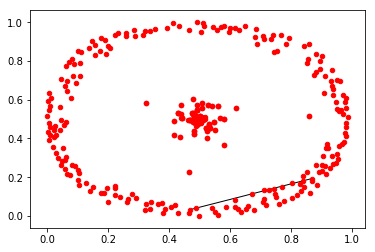

In [53]:
g= nx.spring_layout(new_graph)
nx.draw_networkx_nodes(new_graph,g,new_graph.nodes(),node_size=20)
nx.draw_networkx_edges(new_graph,g)

In [56]:
#Size of the biggest connected component
print('The size of the biggest connected component is '+ str(len(max(nx.connected_component_subgraphs(new_graph), key=len).nodes())))

The size of the biggest connected component is 2339


In [55]:
len(new_graph.nodes())

2642

# 4. Looking at graph properties :

## 4.1 Idea to discuss with ahmed and hani : 

Let's try to find communities of foods by their category on the dataframe (e.g Farines et amidons,Algues) or a simpler communities structure could be fruits and veggies, meats , dairy and so on... 

If we find a way to represent the nodes with colours corresponding to their category, and see clear communities, it would be a big plus for our project.

I will get to doing that next time I touch this notebook, unless, someone beats me to it.

Right after this, we will get to the user model. 

# 5. User model : 